In [1]:

# GBT
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col  
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, min, max, mean, abs as abs_

spark = SparkSession.builder.appName("GBTRegressor Example").getOrCreate()

file = "DT.csv"
df = spark.read.csv(file, header=True, inferSchema=True)


feature_columns = [c for c in df.columns if c != 'yield']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df).select(col("features"), col("yield").alias("label"))

train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=100, seed=42)
model = gbt.fit(train_data)

predictions = model.transform(test_data)








Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/17 12:30:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/17 12:31:01 WARN BlockManager: Asked to remove block broadcast_86, which does not exist


Root Mean Squared Error (RMSE): 529.0778858760128


24/05/17 12:31:36 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/17 12:31:36 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Training Data Metrics:
RMSE: 549.3962443387577
MAE: 409.9416788282054
Minimum Error: 0.0009216863081746851
Maximum Error: 3122.7785109006263
Mean Error: 2.5174757633301193e-13
Pearson Correlation Coefficient: 0.91463019488956

Testing Data Metrics:
RMSE: 529.0778858760128
MAE: 404.8626050857725
Minimum Error: 0.8401240854554999
Maximum Error: 1573.4749622040908
Mean Error: 32.61345161484933
Pearson Correlation Coefficient: 0.9195590981378643
Feature Importances:
RainingDays: 0.33327777087701094
CEII_binned: 0.2819279359146002
clonesize: 0.24405189815706255
honeybee: 0.13487445597584163
AverageRainingDays: 0.0058679390754848085


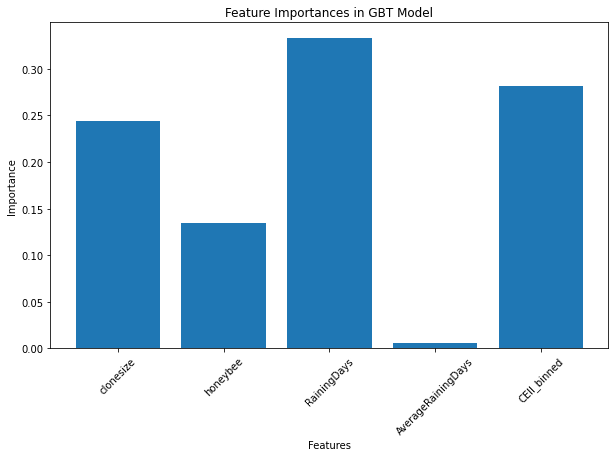

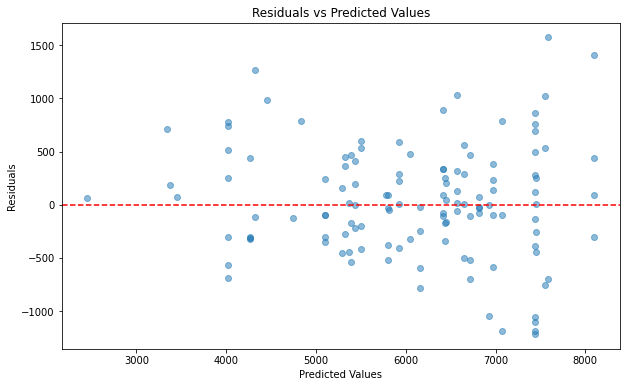

In [13]:
train_predictions = model.transform(train_data)
test_predictions = model.transform(test_data)

train_predictions = train_predictions.withColumn("Error", col("prediction") - col("label"))
test_predictions = test_predictions.withColumn("Error", col("prediction") - col("label"))
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")
train_rmse = evaluator.evaluate(train_predictions, {evaluator.metricName: "rmse"})
test_rmse = evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"})
train_mae = evaluator.evaluate(train_predictions, {evaluator.metricName: "mae"})
test_mae = evaluator.evaluate(test_predictions, {evaluator.metricName: "mae"})
train_min_error = train_predictions.select(min(abs_("Error")).alias("min_error")).collect()[0]["min_error"]
train_max_error = train_predictions.select(max(abs_("Error")).alias("max_error")).collect()[0]["max_error"]
train_mean_error = train_predictions.select(mean("Error").alias("mean_error")).collect()[0]["mean_error"]

test_min_error = test_predictions.select(min(abs_("Error")).alias("min_error")).collect()[0]["min_error"]
test_max_error = test_predictions.select(max(abs_("Error")).alias("max_error")).collect()[0]["max_error"]
test_mean_error = test_predictions.select(mean("Error").alias("mean_error")).collect()[0]["mean_error"]

print("Training Data Metrics:")
print(f"RMSE: {train_rmse}")
print(f"MAE: {train_mae}")
print(f"Minimum Error: {train_min_error}")
print(f"Maximum Error: {train_max_error}")
print(f"Mean Error: {train_mean_error}")
print(f"Pearson Correlation Coefficient: {train_correlation}")

print("\nTesting Data Metrics:")
print(f"RMSE: {test_rmse}")
print(f"MAE: {test_mae}")
print(f"Minimum Error: {test_min_error}")
print(f"Maximum Error: {test_max_error}")
print(f"Mean Error: {test_mean_error}")
print(f"Pearson Correlation Coefficient: {test_correlation}")

feature_importances = model.featureImportances.toArray()
features_and_importances = zip(feature_columns, feature_importances)

sorted_features_and_importances = sorted(features_and_importances, key=lambda x: x[1], reverse=True)

# 打印特征及其重要性
print("Feature Importances:")
for feature, importance in sorted_features_and_importances:
    print(f"{feature}: {importance}")
    
    
plt.figure(figsize=(10, 6))
plt.bar(feature_columns, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in GBT Model')
plt.xticks(rotation=45)
plt.show()


prediction_and_labels = predictions.select("prediction", "label").collect()
preds = [p['prediction'] for p in prediction_and_labels]
labels = [p['label'] for p in prediction_and_labels]
# 计算残差
residuals = [pred - label for pred, label in zip(preds, labels)]

# 绘制残差图
plt.figure(figsize=(10, 6))
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

spark.stop()

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt


spark = SparkSession.builder.appName("KMeans Clustering with PySpark").getOrCreate()

df = spark.read.csv("DT.csv", header=True, inferSchema=True)

feature_columns = df.columns
feature_columns.remove('yield')  

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
vectorized_data = assembler.transform(df)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaled_model = scaler.fit(vectorized_data)
scaled_data = scaled_model.transform(vectorized_data)




kmeans = KMeans(featuresCol="scaledFeatures", predictionCol="prediction", k=4,initSteps=3,tol=1e-4, seed=42)
model = kmeans.fit(scaled_data)

predictions = model.transform(scaled_data)


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/19 05:41:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:


evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="scaledFeatures", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(predictions)
print("Silhouette Score:", silhouette)



Silhouette Score: 0.4496588627625575


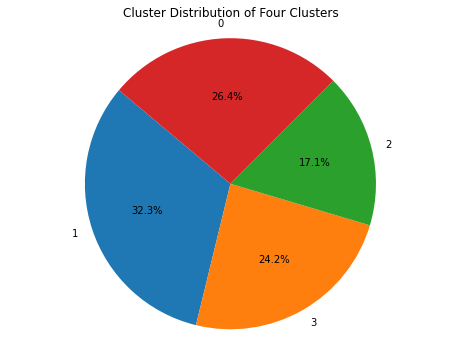

24/05/18 11:25:32 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/18 11:25:32 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
24/05/18 11:25:33 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/05/18 11:25:33 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


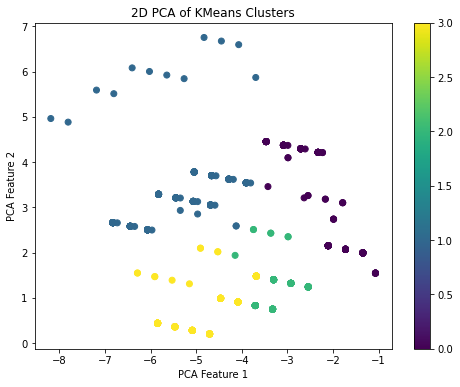

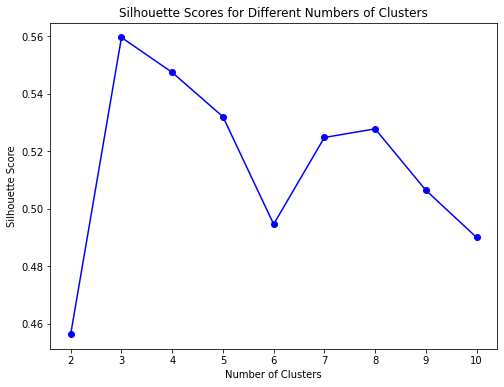

In [4]:
cluster_counts = predictions.groupBy('prediction').count()

cluster_counts_local = cluster_counts.collect()

labels = [str(row['prediction']) for row in cluster_counts_local]
sizes = [row['count'] for row in cluster_counts_local]


plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Cluster Distribution of Four Clusters')
plt.show()


# 使用 PCA 进行降维
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(predictions)
pca_result = pca_model.transform(predictions)

# 收集 PCA 结果和聚类标签用于绘图
pca_features = pca_result.select("pcaFeatures").rdd.map(lambda row: row.pcaFeatures.toArray()).collect()
labels = pca_result.select("prediction").rdd.flatMap(lambda x: x).collect()

# 绘制 PCA 结果
plt.figure(figsize=(8, 6))
plt.scatter([x[0] for x in pca_features], [x[1] for x in pca_features], c=labels, cmap='viridis')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('2D PCA of KMeans Clusters')
plt.colorbar()
plt.show()

# 分析不同聚类数的轮廓系数
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(featuresCol="scaledFeatures", predictionCol="prediction", k=k, seed=42)
    model = kmeans.fit(scaled_data)
    predictions = model.transform(scaled_data)
    score = evaluator.evaluate(predictions)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.show()



